**HOTEL 1**

BLOQUE 1 - MATRIZ CORRELACIÓN DE PEARSON

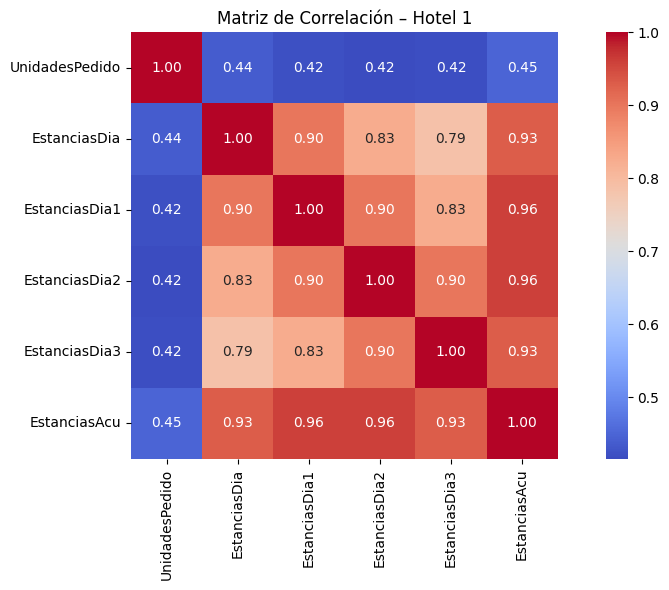

In [17]:
# PASO 1: Librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PASO 2: Leer el archivo
ruta = "/content/Datos Hotel 1 Final Cortado.xlsx"
df = pd.read_excel(ruta)

# PASO 3: Seleccionar variables de interés
cols = ['UnidadesPedido', 'EstanciasDia', 'EstanciasDia1', 'EstanciasDia2', 'EstanciasDia3', 'EstanciasAcu']
df_corr = df[cols].corr()

# PASO 4: Graficar matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación – Hotel 1")
plt.tight_layout()
plt.show()


BLOQUE 2 - MATRIZ DE SIGNIFICATIVIDAD

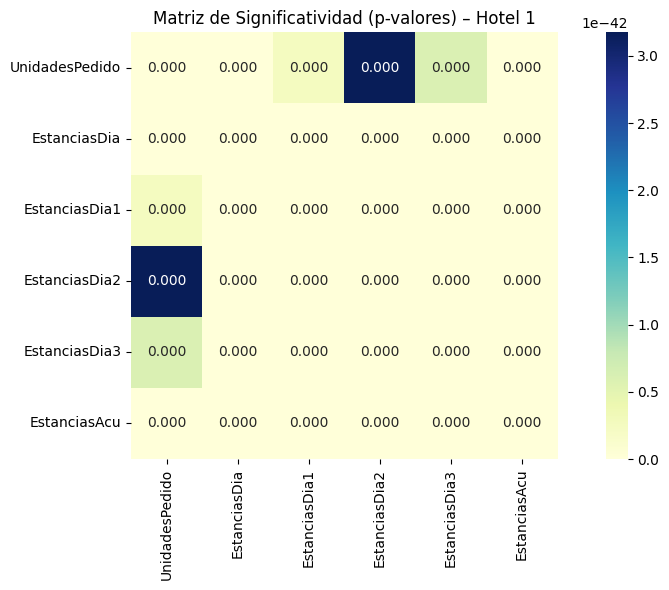

In [18]:
import scipy.stats as stats
import numpy as np

# Calcular matriz de p-valores para comprobar significación estadística
cols = ['UnidadesPedido', 'EstanciasDia', 'EstanciasDia1', 'EstanciasDia2', 'EstanciasDia3', 'EstanciasAcu']
df_selected = df[cols]

# Crear matriz vacía de p-valores
p_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

# Calcular p-valor de cada combinación
for i in cols:
    for j in cols:
        _, p_value = stats.pearsonr(df_selected[i], df_selected[j])
        p_matrix.loc[i, j] = p_value

# Mostrar como heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(p_matrix, annot=True, cmap="YlGnBu", fmt=".3f", square=True)
plt.title("Matriz de Significatividad (p-valores) – Hotel 1")
plt.tight_layout()
plt.show()


BLOQUE 3- Test de Estacionariedad (ADF)

In [19]:
# Instalamos librerías si fuera necesario
!pip install pandas openpyxl statsmodels matplotlib

# Importamos lo necesario
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Cargamos el Excel desde la ruta
ruta_archivo = "/content/Datos Hotel 1 Final Cortado.xlsx"
df = pd.read_excel(ruta_archivo, sheet_name='Hoja1')

# Creamos columna de fecha y agrupamos por semana
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({'UnidadesPedido': 'sum'}).reset_index()
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')

# Hacemos el test de Dickey-Fuller (ADF)
resultado_adf = adfuller(df_grouped['UnidadesPedido'].dropna())

print("Resultado del Test ADF (estacionariedad de la serie) Hotel 1:")
print(f"Estadístico ADF: {resultado_adf[0]:.4f}")
print(f"p-value: {resultado_adf[1]:.4f}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  Nivel {clave}: {valor:.4f}")

if resultado_adf[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0). Usa d=0 en ARIMAX")
else:
    print("La serie NO es estacionaria (no podemos rechazar H0). Usa d=1 en ARIMAX")


Resultado del Test ADF (estacionariedad de la serie) Hotel 1:
Estadístico ADF: -3.4083
p-value: 0.0107
Valores críticos:
  Nivel 1%: -3.4809
  Nivel 5%: -2.8837
  Nivel 10%: -2.5786
La serie es estacionaria (rechazamos H0). Usa d=0 en ARIMAX


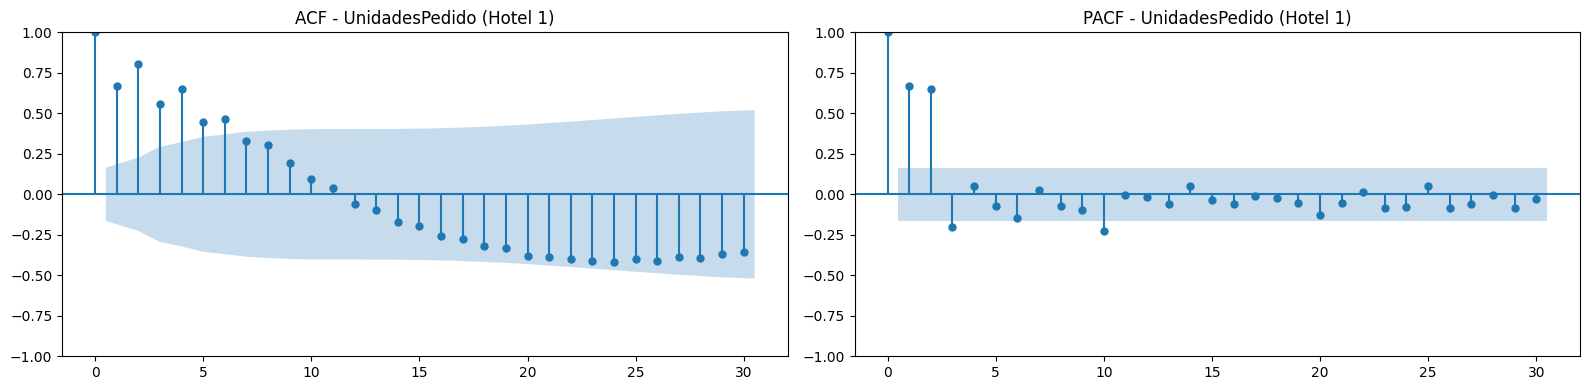

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Seleccionar la serie
y = df_grouped['UnidadesPedido']

# ACF y PACF en horizontal
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(y, lags=30, ax=axes[0])
axes[0].set_title("ACF - UnidadesPedido (Hotel 1)")

# PACF
plot_pacf(y, lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF - UnidadesPedido (Hotel 1)")

plt.tight_layout()
plt.show()


BLOQUE 4 - Modelo SARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

MÉTRICAS TEST:
MAE  = 234.48
RMSE = 316.08
R²   = 0.84

Predicción para la semana 37 (2024-09-09):
Unidades a comprar: 2657
Intervalo 95%: (1932, 3382)


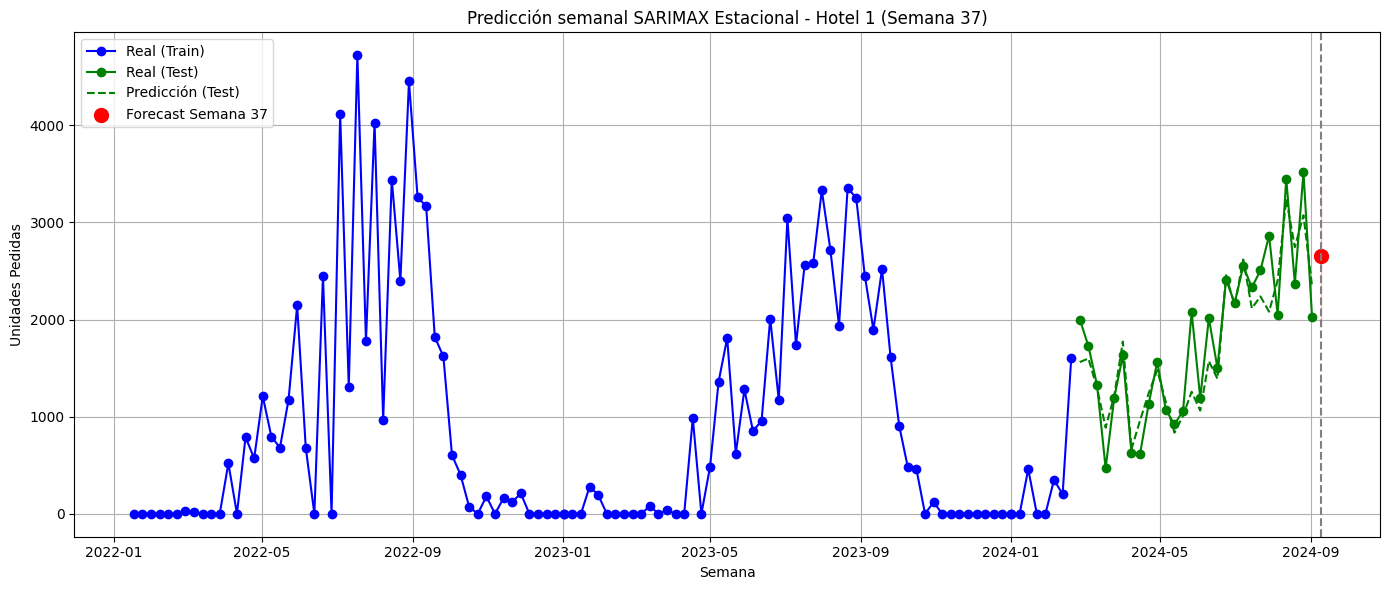

In [3]:
# PASO 1: Librerías
###Bueno2
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# PASO 2: Cargar datos
ruta_archivo = "/content/Datos Hotel 1 Final Cortado.xlsx"
df = pd.read_excel(ruta_archivo, sheet_name='Hoja1')

# PASO 3: Preparación y agregación
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({
    'UnidadesPedido': 'sum',
    'PedidosAcumuladosSemana': 'sum',
    'EstanciasDia': 'sum',
    'EstanciasDia1': 'sum'
}).reset_index()

df_grouped['UnidadesPedido_lag1'] = df_grouped['UnidadesPedido'].shift(2)
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.dropna().sort_values('Fecha').set_index('Fecha')

# PASO 4: Variables
exog_vars = ['PedidosAcumuladosSemana', 'EstanciasDia', 'EstanciasDia1', 'UnidadesPedido_lag1']
X = df_grouped[exog_vars]
y = df_grouped['UnidadesPedido']

# Normalización de X e Y
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train/Test Split
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
index = df_grouped.index

# PASO 5: Entrenamiento SARIMAX estacional
modelo = SARIMAX(y_train, exog=X_train, order=(2, 0, 2), seasonal_order=(1, 0, 1, 52),
                 enforce_stationarity=True, enforce_invertibility=True)
resultado = modelo.fit()

# Predicción en TEST
pred_scaled = resultado.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
pred_test = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# PASO 6: Forecast semana 37 (reentrenamiento completo)
modelo_final = SARIMAX(y_scaled, exog=X_scaled, order=(1, 0, 1), seasonal_order=(1, 0, 1, 52),
                       enforce_stationarity=True, enforce_invertibility=True)
resultado_final = modelo_final.fit()

ultimo_x = X_scaled[[-1]]
forecast = resultado_final.get_forecast(steps=1, exog=ultimo_x)
forecast_mean = scaler_y.inverse_transform(forecast.predicted_mean.reshape(-1, 1)).flatten()[0]
conf_int_scaled = forecast.conf_int()
conf_int = scaler_y.inverse_transform(conf_int_scaled).flatten()
fecha_pred = index[-1] + pd.Timedelta(weeks=1)

# PASO 7: Métricas
mae = mean_absolute_error(y_test_real, pred_test)
rmse = np.sqrt(mean_squared_error(y_test_real, pred_test))
r2 = r2_score(y_test_real, pred_test)

print("MÉTRICAS TEST:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}\n")
print(f"Predicción para la semana 37 ({fecha_pred.date()}):")
print(f"Unidades a comprar: {forecast_mean:.0f}")
print(f"Intervalo 95%: ({conf_int[0]:.0f}, {conf_int[1]:.0f})")

# PASO 8: Gráfico
plt.figure(figsize=(14, 6))
plt.plot(index[:train_size], scaler_y.inverse_transform(y_scaled[:train_size].reshape(-1, 1)), label='Real (Train)', color='blue', marker='o')
plt.plot(index[train_size:], y_test_real, label='Real (Test)', color='green', marker='o')
plt.plot(index[train_size:], pred_test, label='Predicción (Test)', linestyle='--', color='green')
plt.scatter(fecha_pred, forecast_mean, color='red', label='Forecast Semana 37', s=100)
plt.fill_between([fecha_pred], conf_int[0], conf_int[1], color='red', alpha=0.3)
plt.axvline(fecha_pred, color='gray', linestyle='--')
plt.title('Predicción semanal SARIMAX Estacional - Hotel 1 (Semana 37)')
plt.xlabel('Semana')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Extraer índice temporal completo desde df_grouped
index = df_grouped.index

# Recalcular fechas del conjunto de test
fechas_test = index[train_size:]

# Crear DataFrame con valores reales y predichos
df_resultados = pd.DataFrame({
    'Fecha': fechas_test,
    'Unidades_Reales': y_test_real,
    'Unidades_Predichas': pred_test
})

# Añadir fila del forecast (semana 37)
forecast_row = pd.DataFrame({
    'Fecha': [fecha_pred],
    'Unidades_Reales': [None],
    'Unidades_Predichas': [forecast_mean]
})
df_resultados = pd.concat([df_resultados, forecast_row], ignore_index=True)

# Guardar como Excel
nombre_archivo = 'Predicciones_Hotel1.xlsx'
df_resultados.to_excel(nombre_archivo, index=False)

# Descargar en Colab
from google.colab import files
files.download(nombre_archivo)


<ipython-input-4-68749f025513>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, forecast_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

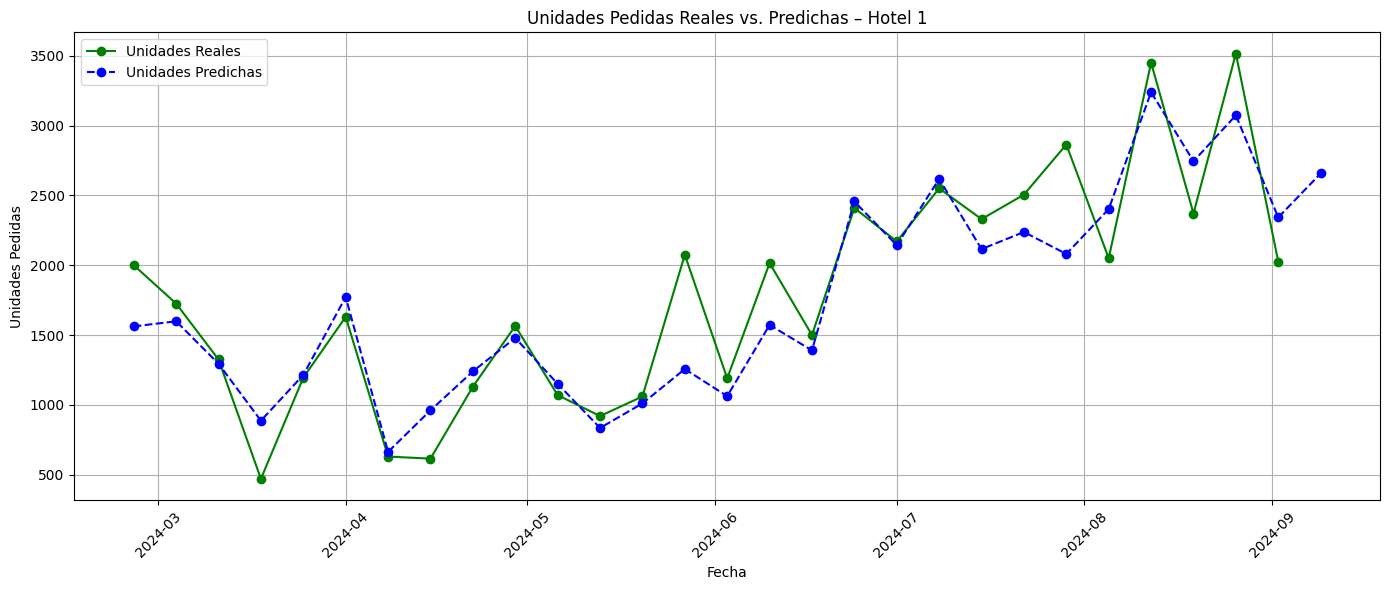

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo Excel con los resultados
df = pd.read_excel("Predicciones_Hotel1.xlsx")

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Crear el gráfico de líneas
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'], df['Unidades_Reales'], label='Unidades Reales', color='green', marker='o')
plt.plot(df['Fecha'], df['Unidades_Predichas'], label='Unidades Predichas', color='blue', linestyle='--', marker='o')

# Título y etiquetas
plt.title('Unidades Pedidas Reales vs. Predichas – Hotel 1')
plt.xlabel('Fecha')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


BLOQUE 5 - TEST JARQUE-BERA Y LJUNG-BOX

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

# --- RESIDUOS TEST ---
residuos = y_test_real - pred_test

#TEST DE JARQUE-BERA (normalidad)
jb_stat, jb_pvalue = jarque_bera(residuos)
print("TEST DE JARQUE-BERA (Normalidad de residuos)")
print(f"Estadístico JB: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print("No se rechaza H0: los residuos siguen una distribución normal")
else:
    print("Se rechaza H0: los residuos NO siguen una distribución normal")

#TEST DE LJUNG-BOX (ruido blanco)
lb_result = acorr_ljungbox(residuos, lags=[10], return_df=True)
lb_stat = lb_result['lb_stat'].values[0]
lb_pvalue = lb_result['lb_pvalue'].values[0]
print("TEST DE LJUNG-BOX (Ruido blanco)")
print(f"Estadístico LB (lag=10): {lb_stat:.4f}")
print(f"p-value: {lb_pvalue:.4f}")
if lb_pvalue > 0.05:
    print("No se rechaza H0: los residuos se comportan como ruido blanco (no hay autocorrelación)")
else:
    print("Se rechaza H0: los residuos NO son ruido blanco (hay autocorrelación)")


TEST DE JARQUE-BERA (Normalidad de residuos)
Estadístico JB: 1.9239
p-value: 0.3822
No se rechaza H0: los residuos siguen una distribución normal
TEST DE LJUNG-BOX (Ruido blanco)
Estadístico LB (lag=10): 16.9344
p-value: 0.0758
No se rechaza H0: los residuos se comportan como ruido blanco (no hay autocorrelación)


**HOTEL 2**

BLOQUE 1 - MATRIZ CORRELACIÓN DE PEARSON

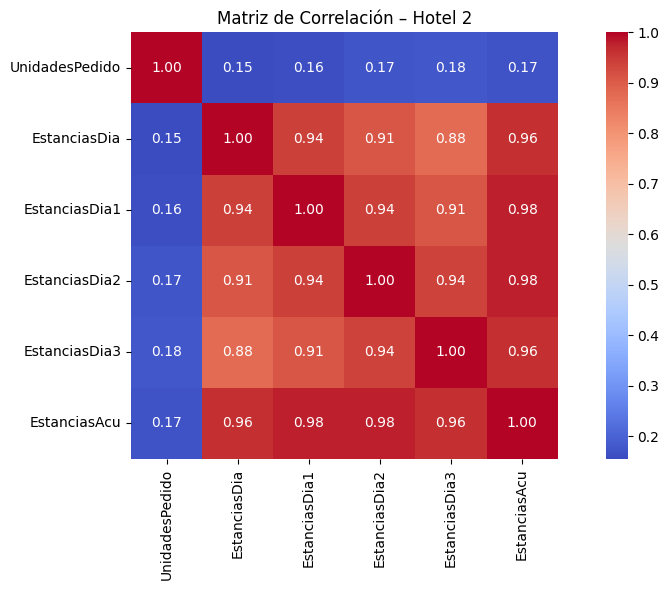

In [4]:
#Leer el archivo
ruta_hotel2 = "/content/Hotel2 Datos Finales Cortado.xlsx"
df_h2 = pd.read_excel(ruta_hotel2)

import seaborn as sns

# Seleccionar las variables relevantes para Hotel 2
cols_h2 = ['UnidadesPedido', 'EstanciasDia', 'EstanciasDia1', 'EstanciasDia2', 'EstanciasDia3', 'EstanciasAcu']
df_corr_h2 = df_h2[cols_h2].corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr_h2, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación – Hotel 2")
plt.tight_layout()
plt.show()




BLOQUE 2- MATRIZ DE SIGNIFICATIVIDAD

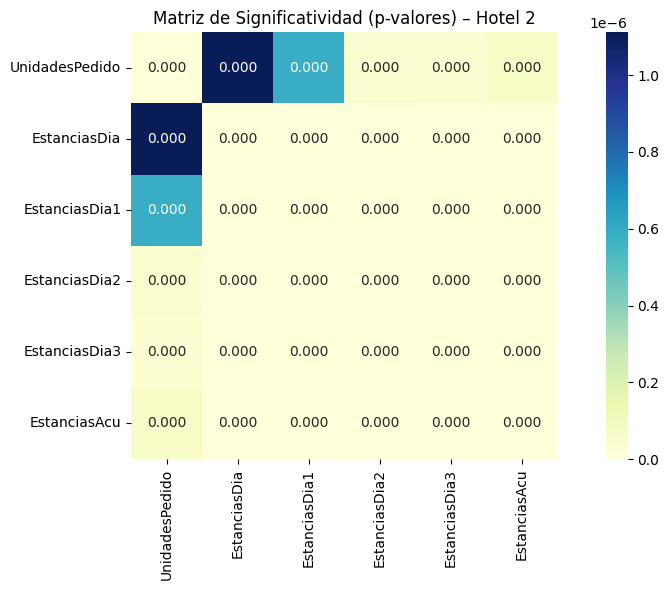

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


p_matrix_h2 = pd.DataFrame(np.ones((len(cols_h2), len(cols_h2))), columns=cols_h2, index=cols_h2)

for i in cols_h2:
    for j in cols_h2:
        _, p_val = stats.pearsonr(df_h2[i], df_h2[j])
        p_matrix_h2.loc[i, j] = p_val

# Graficar matriz de p-valores
plt.figure(figsize=(10, 6))
sns.heatmap(p_matrix_h2, annot=True, cmap="YlGnBu", fmt=".3f", square=True)
plt.title("Matriz de Significatividad (p-valores) – Hotel 2")
plt.tight_layout()
plt.show()


BLOQUE 3- Test de Estacionariedad (ADF)

In [8]:
# PASO 1: Instalar librerías si estás en Google Colab
!pip install pandas openpyxl statsmodels matplotlib

# PASO 2: Importaciones
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# PASO 3: Cargar archivo del Hotel 2
ruta_archivo = "/content/Hotel2 Datos Finales Cortado.xlsx"
df = pd.read_excel(ruta_archivo)

# PASO 4: Agrupar por semana y preparar la serie
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({'UnidadesPedido': 'sum'}).reset_index()

# Crear columna de fecha semanal (lunes de cada semana)
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')

# PASO 5: Test de Dickey-Fuller
resultado_adf = adfuller(df_grouped['UnidadesPedido'].dropna())

print("Resultado del Test ADF (estacionariedad de la serie) Hotel 2:")
print(f"Estadístico ADF: {resultado_adf[0]:.4f}")
print(f"p-value: {resultado_adf[1]:.4f}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  Nivel {clave}: {valor:.4f}")

if resultado_adf[1] < 0.05:
    print("La serie es estacionaria (se rechaza H0). Usa d=0 en ARIMAX.")
else:
    print("La serie NO es estacionaria (no se rechaza H0). Usa d=1 en ARIMAX.")


Resultado del Test ADF (estacionariedad de la serie) Hotel 2:
Estadístico ADF: -2.2789
p-value: 0.1789
Valores críticos:
  Nivel 1%: -3.4813
  Nivel 5%: -2.8839
  Nivel 10%: -2.5787
La serie NO es estacionaria (no se rechaza H0). Usa d=1 en ARIMAX.


BLOQUE 4- Test de Estacionariedad (ADF) - Sobre la serie diferenciada

In [9]:
# PASO 1: Importar librerías necesarias
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# PASO 2: Cargar el archivo original
ruta_archivo = "/content/Hotel2 Datos Finales Cortado.xlsx"
df = pd.read_excel(ruta_archivo)

# PASO 3: Crear df_grouped (agregado semanal)
df['Fecha'] = pd.to_datetime(df['Fecha'])

df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({
    'UnidadesPedido': 'sum',
    'PedidosAcumuladosSemana': 'sum',
    'EstanciasDia': 'sum',
    'EstanciasDia1': 'sum',
    'EstanciasAcu': 'sum'
}).reset_index()

df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')


In [10]:
# Serie diferenciada
y = df_grouped['UnidadesPedido']
y_diff = y.diff().dropna()

# Test ADF
resultado_adf_diff = adfuller(y_diff)

print("Test ADF sobre la serie diferenciada (d=1):")
print(f"Estadístico ADF: {resultado_adf_diff[0]:.4f}")
print(f"p-value: {resultado_adf_diff[1]:.4f}")
print("Valores críticos:")
for clave, valor in resultado_adf_diff[4].items():
    print(f" Nivel {clave}: {valor:.4f}")

if resultado_adf_diff[1] < 0.05:
    print("La serie diferenciada ES estacionaria. Puedes usar d=1 en ARIMAX.")
else:
    print("La serie diferenciada NO es estacionaria.")


Test ADF sobre la serie diferenciada (d=1):
Estadístico ADF: -8.5080
p-value: 0.0000
Valores críticos:
 Nivel 1%: -3.4794
 Nivel 5%: -2.8830
 Nivel 10%: -2.5782
La serie diferenciada ES estacionaria. Puedes usar d=1 en ARIMAX.


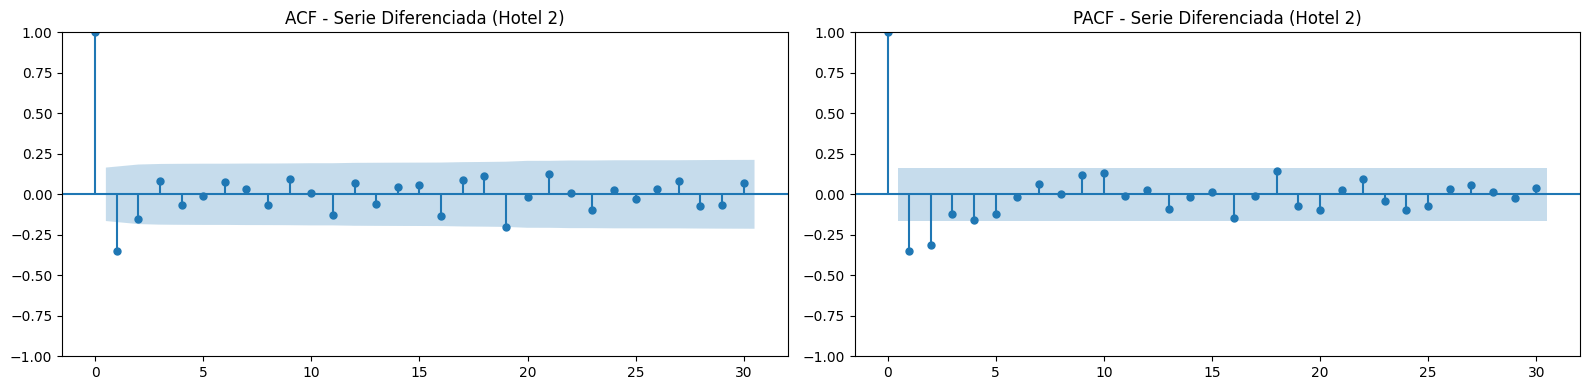

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Crear una figura con 2 subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(y_diff, lags=30, ax=axes[0])
axes[0].set_title("ACF - Serie Diferenciada (Hotel 2)")

# PACF
plot_pacf(y_diff, lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Serie Diferenciada (Hotel 2)")

plt.tight_layout()
plt.show()


BLOQUE 5- Modelo ARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MÉTRICAS TEST:
MAE  = 2.97
RMSE = 3.55
R²   = 0.68

Predicción semana 37 (2024-09-09): 33 unidades
Intervalo 95%: (21, 45)


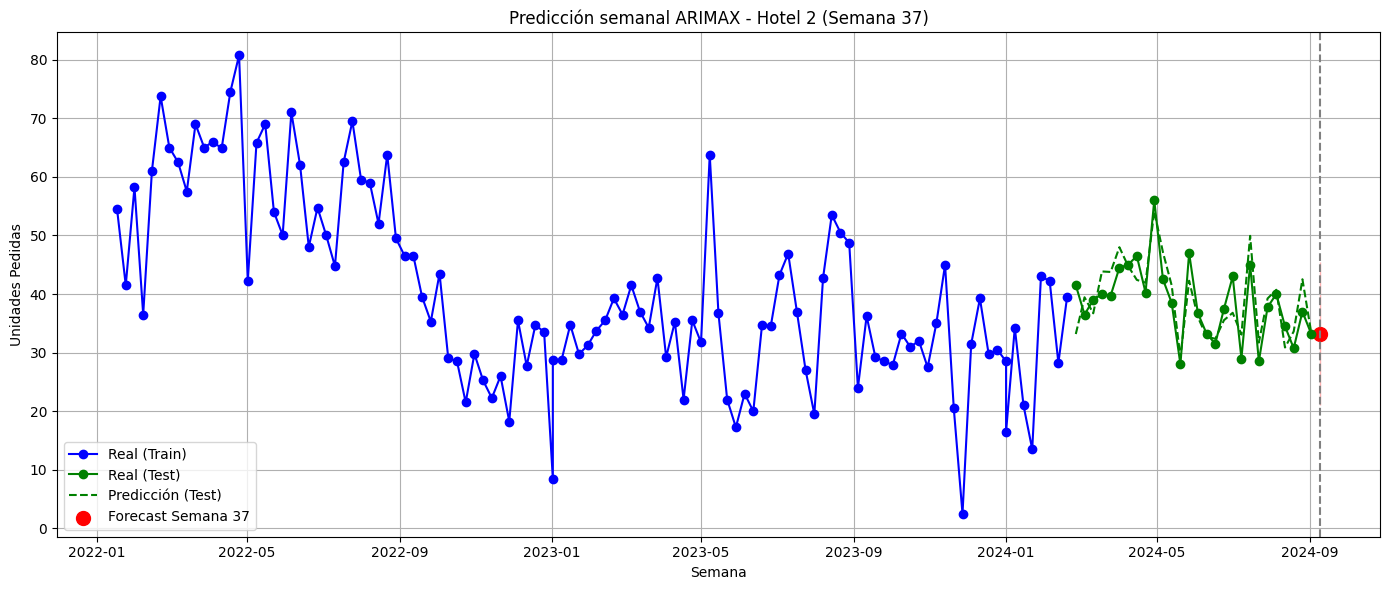

In [15]:
# PASO 1: Librerías
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# PASO 2: Cargar archivo
ruta_archivo = "/content/Hotel2 Datos Finales Cortado.xlsx"
df = pd.read_excel(ruta_archivo)

# PASO 3: Preparación y agregación semanal
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({
    'UnidadesPedido': 'sum',
    'PedidosAcumuladosSemana': 'sum',
    'EstanciasDia': 'sum',
    'EstanciasDia1': 'sum',
    'EstanciasAcu': 'sum'
}).reset_index()

df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')
df_grouped['UnidadesPedido_lag1'] = df_grouped['UnidadesPedido'].shift(2)
df_model = df_grouped.dropna()

# PASO 4: Variables
exog_vars = ['PedidosAcumuladosSemana', 'EstanciasDia', 'EstanciasDia1', 'EstanciasAcu', 'UnidadesPedido_lag1']
X = df_model[exog_vars]
y = df_model['UnidadesPedido']

# PASO 5: División Train/Test
train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# PASO 6: Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PASO 7: Entrenar ARIMAX con d=1
modelo = SARIMAX(y_train, exog=X_train_scaled, order=(1, 1, 1), enforce_stationarity=True, enforce_invertibility=True)
resultado = modelo.fit()

# PASO 8: Reentrenar con todo + forecast
modelo_test = SARIMAX(pd.concat([y_train, y_test]), exog=scaler.fit_transform(pd.concat([X_train, X_test])),
                      order=(1, 1, 1), enforce_stationarity=True, enforce_invertibility=True)
resultado_test = modelo_test.fit()

pred_test = resultado_test.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test_scaled)

# PASO 9: Forecast semana 37
ultimo_x = X.iloc[[-1]]
ultimo_x_scaled = scaler.transform(ultimo_x)
forecast_future = resultado_test.get_forecast(steps=1, exog=ultimo_x_scaled)
forecast_1week = forecast_future.predicted_mean
conf_int = forecast_future.conf_int()
fecha_forecast = y.index[-1] + pd.Timedelta(weeks=1)

# PASO 10: Métricas
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
r2 = r2_score(y_test, pred_test)

print("MÉTRICAS TEST:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}\n")
print(f"Predicción semana 37 ({fecha_forecast.date()}): {forecast_1week.iloc[0]:.0f} unidades")
print(f"Intervalo 95%: ({conf_int.iloc[0, 0]:.0f}, {conf_int.iloc[0, 1]:.0f})")

# PASO 11: Gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Real (Train)', color='blue', marker='o')
plt.plot(y_test.index, y_test, label='Real (Test)', color='green', marker='o')
plt.plot(y_test.index, pred_test, label='Predicción (Test)', linestyle='--', color='green')
plt.scatter(fecha_forecast, forecast_1week, color='red', label='Forecast Semana 37', s=100)
plt.fill_between([fecha_forecast, fecha_forecast], conf_int.iloc[0, 0], conf_int.iloc[0, 1], color='red', alpha=0.3)
plt.axvline(fecha_forecast, color='gray', linestyle='--')
plt.title('Predicción semanal ARIMAX - Hotel 2 (Semana 37)')
plt.xlabel('Semana')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# PASO 12: Exportar resultados reales vs. predichos a Excel

# Concatenar fechas de test
fechas_test = y_test.index

# Crear DataFrame con reales y predichos
df_resultados_h2 = pd.DataFrame({
    'Fecha': fechas_test,
    'Unidades_Reales': y_test.values,
    'Unidades_Predichas': pred_test.values
})

# Añadir fila del forecast semana 37
forecast_row = pd.DataFrame({
    'Fecha': [fecha_forecast],
    'Unidades_Reales': [None],
    'Unidades_Predichas': [forecast_1week.iloc[0]]
})
df_resultados_h2 = pd.concat([df_resultados_h2, forecast_row], ignore_index=True)

# Guardar archivo Excel
nombre_archivo = 'Predicciones_Hotel2.xlsx'
df_resultados_h2.to_excel(nombre_archivo, index=False)

# Descargar desde Colab
from google.colab import files
files.download(nombre_archivo)


<ipython-input-16-67ba66f3142f>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados_h2 = pd.concat([df_resultados_h2, forecast_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

# Obtener residuos del modelo test
residuos_val_H2 = resultado_test.resid

# Test de Jarque-Bera
jb_stat, jb_pval = jarque_bera(residuos_val_H2)
print("Test Jarque-Bera (normalidad residuos – Hotel 2):")
print(f"Estadístico = {jb_stat:.2f} | p-valor = {jb_pval:.4f}")
if jb_pval > 0.05:
    print("No se rechaza H₀: residuos normales")
else:
    print("Se rechaza H₀: residuos NO normales")

# Test de Ljung-Box
ljung_test_H2 = acorr_ljungbox(residuos_val_H2, lags=[10], return_df=True)
print("\nTest Ljung-Box (autocorrelación residuos – Hotel 2):")
print(ljung_test_H2)

if ljung_test_H2['lb_pvalue'].iloc[0] > 0.05:
    print("No se rechaza H₀: residuos = ruido blanco")
else:
    print("Se rechaza H₀: hay autocorrelación en los residuos")


Test Jarque-Bera (normalidad residuos – Hotel 2):
Estadístico = 790.72 | p-valor = 0.0000
Se rechaza H₀: residuos NO normales

Test Ljung-Box (autocorrelación residuos – Hotel 2):
     lb_stat  lb_pvalue
10  6.504897   0.771212
No se rechaza H₀: residuos = ruido blanco


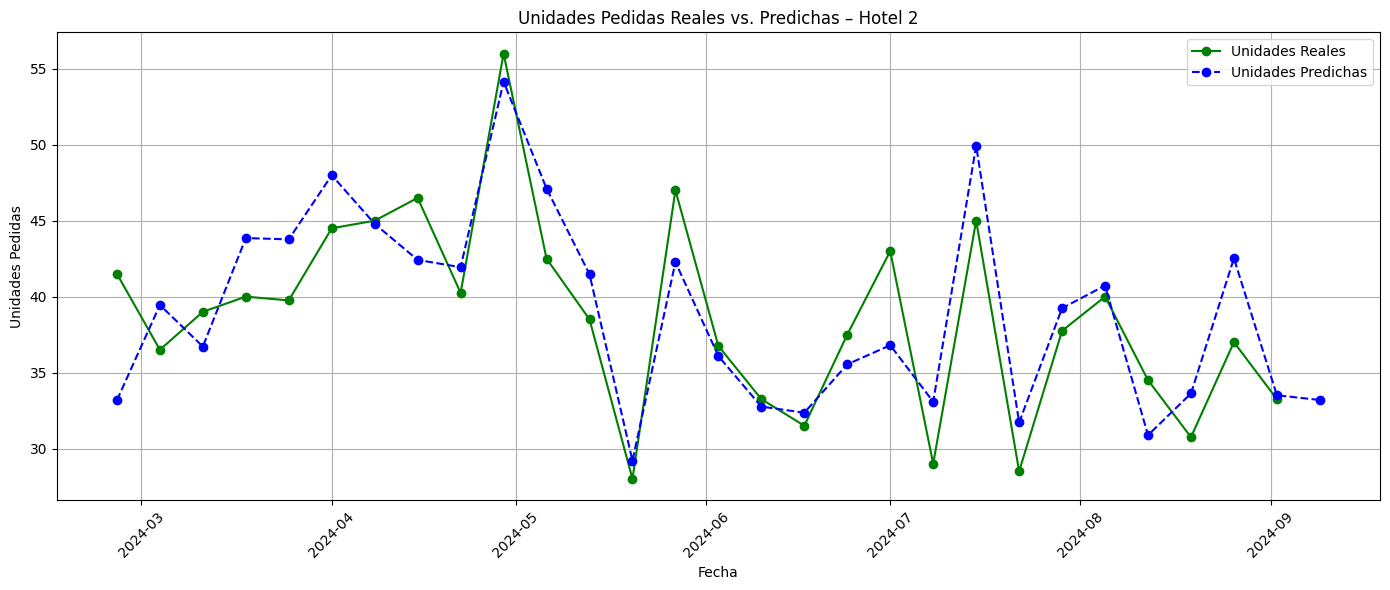

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo Excel
df = pd.read_excel("Predicciones_Hotel2.xlsx")

# Asegurar que la columna 'Fecha' esté en formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Crear el gráfico de líneas
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'], df['Unidades_Reales'], label='Unidades Reales', color='green', marker='o')
plt.plot(df['Fecha'], df['Unidades_Predichas'], label='Unidades Predichas', color='blue', linestyle='--', marker='o')

# Añadir etiquetas y formato
plt.title('Unidades Pedidas Reales vs. Predichas – Hotel 2')
plt.xlabel('Fecha')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**HOTEL 3**


BLOQUE 1 - MATRIZ CORRELACIÓN DE PEARSON

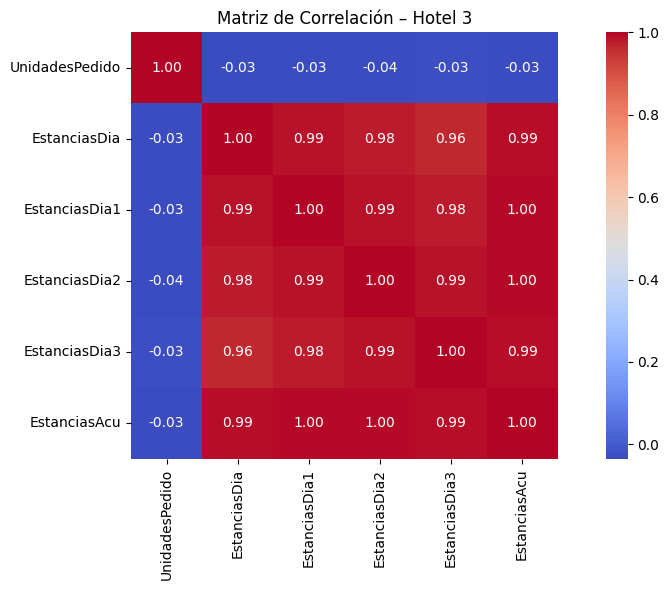

In [ ]:
# PASO 1: Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PASO 2: Ruta del archivo del Hotel 3
ruta_hotel3 = "/content/Hote3 Datos Finales Cortado.xlsx"
df_h3 = pd.read_excel(ruta_hotel3)

# PASO 3: Seleccionar columnas relevantes
cols_h3 = ['UnidadesPedido', 'EstanciasDia', 'EstanciasDia1', 'EstanciasDia2', 'EstanciasDia3', 'EstanciasAcu']
df_corr_h3 = df_h3[cols_h3].corr()

# PASO 4: Graficar la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr_h3, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación – Hotel 3")
plt.tight_layout()
plt.show()


BLOQUE 2- MATRIZ DE SIGNIFICATIVIDAD

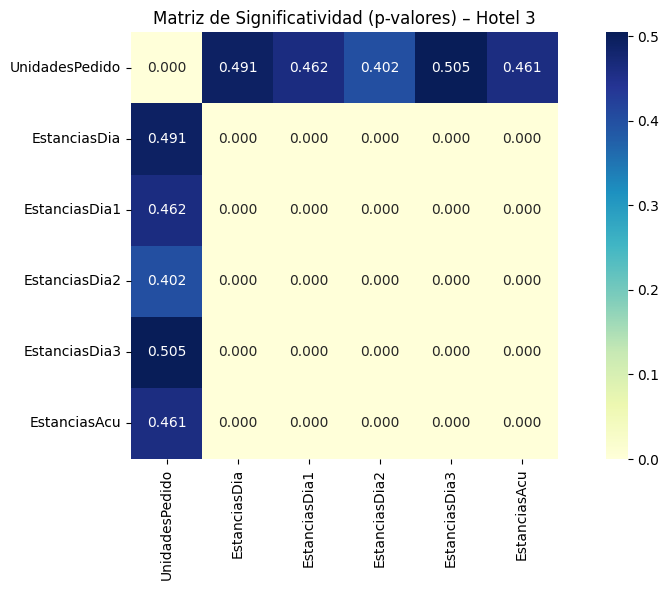

In [ ]:

from scipy.stats import pearsonr
import numpy as np

# Selección de columnas
cols_h3 = ['UnidadesPedido', 'EstanciasDia', 'EstanciasDia1', 'EstanciasDia2', 'EstanciasDia3', 'EstanciasAcu']
df_selected_h3 = df_h3[cols_h3]

# Crear matriz vacía de p-valores
p_matrix_h3 = pd.DataFrame(np.ones((len(cols_h3), len(cols_h3))), columns=cols_h3, index=cols_h3)

# Calcular p-valor para cada par
for i in cols_h3:
    for j in cols_h3:
        _, p_val = pearsonr(df_selected_h3[i], df_selected_h3[j])
        p_matrix_h3.loc[i, j] = p_val

# Graficar la matriz de significatividad
plt.figure(figsize=(10, 6))
sns.heatmap(p_matrix_h3, annot=True, cmap="YlGnBu", fmt=".3f", square=True)
plt.title("Matriz de Significatividad (p-valores) – Hotel 3")
plt.tight_layout()
plt.show()


BLOQUE 3- Test de Estacionariedad (ADF)

In [ ]:
# Instalamos librerías si fuera necesario
!pip install pandas openpyxl statsmodels matplotlib

# Importamos lo necesario
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Cargamos el Excel desde la ruta
ruta_archivo = "/content/Hote3 Datos Finales Cortado.xlsx"
df = pd.read_excel(ruta_archivo, sheet_name='Hoja1')

# Creamos columna de fecha y agrupamos por semana
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({'UnidadesPedido': 'sum'}).reset_index()
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')

# Hacemos el test de Dickey-Fuller (ADF)
resultado_adf = adfuller(df_grouped['UnidadesPedido'].dropna())

print("Resultado del Test ADF (estacionariedad de la serie) Hotel 3:")
print(f"Estadístico ADF: {resultado_adf[0]:.4f}")
print(f"p-value: {resultado_adf[1]:.4f}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  Nivel {clave}: {valor:.4f}")

if resultado_adf[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0). Usa d=0 en ARIMAX")
else:
    print("La serie NO es estacionaria (no podemos rechazar H0). Usa d=1 en ARIMAX")


Resultado del Test ADF (estacionariedad de la serie) Hotel 3:
Estadístico ADF: -3.9622
p-value: 0.0016
Valores críticos:
  Nivel 1%: -3.4786
  Nivel 5%: -2.8827
  Nivel 10%: -2.5781
La serie es estacionaria (rechazamos H0). Usa d=0 en ARIMAX


BLOQUE 4: ACF Y PACF

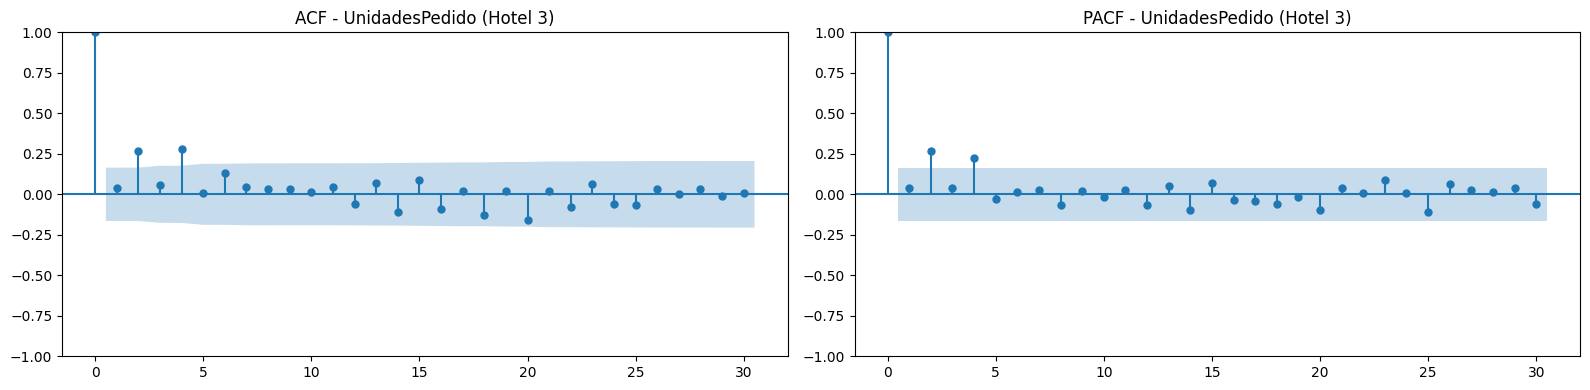

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Suponiendo que y_h3 es tu serie temporal ya ordenada
y_h3 = df_grouped['UnidadesPedido']

# Crear figura con 2 subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(y_h3, lags=30, ax=axes[0])
axes[0].set_title("ACF - UnidadesPedido (Hotel 3)")

# PACF
plot_pacf(y_h3, lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF - UnidadesPedido (Hotel 3)")

plt.tight_layout()
plt.show()


BLOQUE 4 - MODELO ARIMAX

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels

MÉTRICAS TEST:
MAE  = 6.47
RMSE = 8.42
R²   = 0.91

Predicción semana 37 (2024-09-09): 29 unidades
Intervalo 95%: (13, 45)


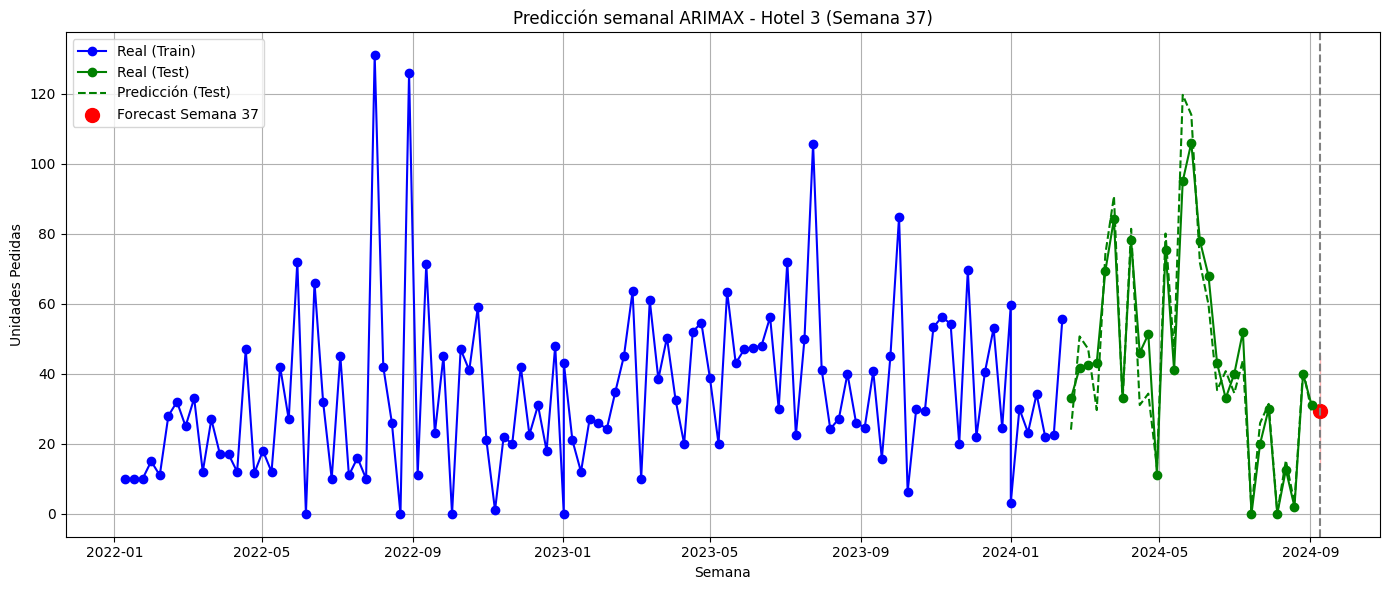

In [19]:
# PASO 1: Librerías
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# PASO 2: Cargar archivo del Hotel 3
ruta_archivo = "/content/Hote3 Datos Finales Cortado.xlsx"
df = pd.read_excel(ruta_archivo)

# PASO 3: Preparación y agregación semanal
df['Fecha'] = pd.to_datetime(df['Fecha'])
df_grouped = df.groupby(['Anio', 'Semana_anio']).agg({
    'UnidadesPedido': 'sum',
    'PedidosAcumuladosSemana': 'sum',
    'EstanciasDia': 'sum',
    'EstanciasDia1': 'sum',
    'EstanciasAcu': 'sum'
}).reset_index()

df_grouped['Fecha'] = pd.to_datetime(df_grouped['Anio'].astype(str) + df_grouped['Semana_anio'].astype(str) + '1', format='%G%V%u')
df_grouped = df_grouped.sort_values('Fecha').set_index('Fecha')

# Añadir lag
df_grouped['UnidadesPedido_lag1'] = df_grouped['UnidadesPedido'].shift(1)
df_model = df_grouped.dropna()

# PASO 4: Variables
exog_vars = ['PedidosAcumuladosSemana', 'EstanciasDia', 'EstanciasDia1', 'EstanciasAcu', 'UnidadesPedido_lag1']
X = df_model[exog_vars]
y = df_model['UnidadesPedido']

# PASO 5: División Train/Test
train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# PASO 6: Escalado
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# PASO 7: Entrenar ARIMAX (d=0)
modelo = SARIMAX(y_train_scaled, exog=X_train_scaled, order=(2, 0, 1),
                 enforce_stationarity=True, enforce_invertibility=True)
resultado = modelo.fit()

# PASO 8: Reentrenar con todo + predicción test
X_total_scaled = scaler_X.fit_transform(pd.concat([X_train, X_test]))
y_total_scaled = scaler_y.fit_transform(pd.concat([y_train, y_test]).values.reshape(-1, 1)).flatten()
modelo_test = SARIMAX(y_total_scaled, exog=X_total_scaled, order=(2, 0, 1),
                      enforce_stationarity=True, enforce_invertibility=True)
resultado_test = modelo_test.fit()

pred_scaled = resultado_test.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test_scaled)
pred_test = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
y_test_real = y_test.values

# PASO 9: Predicción semana 37 (2024-09-09)
ultimo_x_scaled = scaler_X.transform(X.iloc[[-1]])
forecast_future = resultado_test.get_forecast(steps=1, exog=ultimo_x_scaled)
forecast_scaled = forecast_future.predicted_mean
conf_int_scaled = forecast_future.conf_int()
forecast_1week = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()[0]
conf_int = scaler_y.inverse_transform(conf_int_scaled).flatten()
fecha_forecast = y.index[-1] + pd.Timedelta(weeks=1)

# PASO 10: Métricas
mae = mean_absolute_error(y_test_real, pred_test)
rmse = np.sqrt(mean_squared_error(y_test_real, pred_test))
r2 = r2_score(y_test_real, pred_test)

print("MÉTRICAS TEST:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}\n")
print(f"Predicción semana 37 ({fecha_forecast.date()}): {forecast_1week:.0f} unidades")
print(f"Intervalo 95%: ({conf_int[0]:.0f}, {conf_int[1]:.0f})")

# PASO 11: Gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Real (Train)', color='blue', marker='o')
plt.plot(y_test.index, y_test_real, label='Real (Test)', color='green', marker='o')
plt.plot(y_test.index, pred_test, label='Predicción (Test)', linestyle='--', color='green')
plt.scatter(fecha_forecast, forecast_1week, color='red', label='Forecast Semana 37', s=100)
plt.fill_between([fecha_forecast], conf_int[0], conf_int[1], color='red', alpha=0.3)
plt.axvline(fecha_forecast, color='gray', linestyle='--')
plt.title('Predicción semanal ARIMAX - Hotel 3 (Semana 37)')
plt.xlabel('Semana')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# PASO 12: Exportar resultados reales vs. predichos a Excel – Hotel 3

# Fechas del conjunto de test
fechas_test = y_test.index

# Crear DataFrame con reales y predichos
df_resultados_h3 = pd.DataFrame({
    'Fecha': fechas_test,
    'Unidades_Reales': y_test_real,
    'Unidades_Predichas': pred_test
})

# Añadir forecast semana 37
forecast_row = pd.DataFrame({
    'Fecha': [fecha_forecast],
    'Unidades_Reales': [None],
    'Unidades_Predichas': [forecast_1week]
})
df_resultados_h3 = pd.concat([df_resultados_h3, forecast_row], ignore_index=True)

# Guardar como Excel
nombre_archivo = 'Predicciones_Hotel3.xlsx'
df_resultados_h3.to_excel(nombre_archivo, index=False)

# Descargar desde Colab
from google.colab import files
files.download(nombre_archivo)


<ipython-input-20-c7aad9593327>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados_h3 = pd.concat([df_resultados_h3, forecast_row], ignore_index=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

# Obtener residuos del modelo ajustado (resultado)
residuos = resultado.resid

# Test de Jarque-Bera (normalidad de residuos)
jb_stat, jb_p = jarque_bera(residuos)
print("Test de Jarque-Bera (normalidad):")
print(f"Estadístico JB: {jb_stat:.4f}")
print(f"p-valor: {jb_p:.4f}")
if jb_p < 0.05:
    print("Se rechaza H₀: los residuos NO son normales\n")
else:
    print("No se rechaza H₀: los residuos podrían ser normales\n")

# Test de Ljung-Box (ruido blanco)
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print("Test de Ljung-Box (ruido blanco):")
print(lb_test)
if lb_test["lb_pvalue"].values[0] < 0.05:
    print("Se rechaza H₀: hay autocorrelación en los residuos")
else:
    print("No se rechaza H₀: los residuos se comportan como ruido blanco")


Test de Jarque-Bera (normalidad):
Estadístico JB: 931.7567
p-valor: 0.0000
Se rechaza H₀: los residuos NO son normales

Test de Ljung-Box (ruido blanco):
     lb_stat  lb_pvalue
10  5.386624   0.863902
No se rechaza H₀: los residuos se comportan como ruido blanco


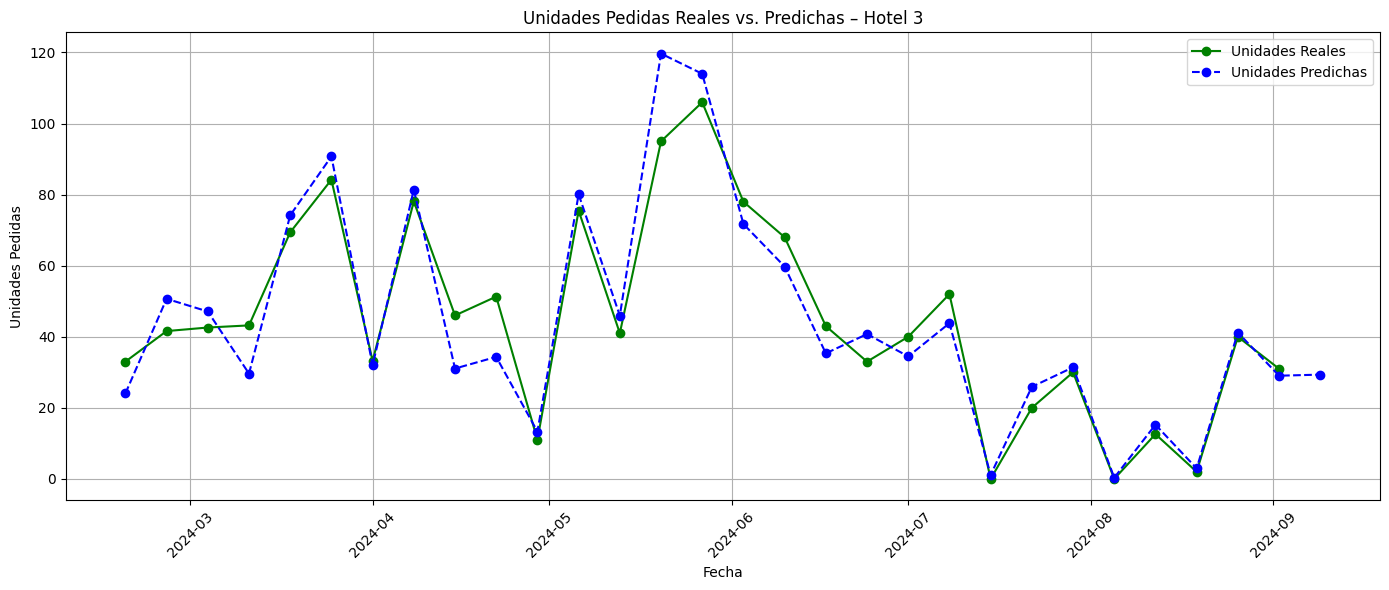

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo Excel
df = pd.read_excel("Predicciones_Hotel3.xlsx")

# Asegurar formato datetime para la columna Fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Crear gráfico de líneas
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'], df['Unidades_Reales'], label='Unidades Reales', color='green', marker='o')
plt.plot(df['Fecha'], df['Unidades_Predichas'], label='Unidades Predichas', color='blue', linestyle='--', marker='o')

# Formato del gráfico
plt.title('Unidades Pedidas Reales vs. Predichas – Hotel 3')
plt.xlabel('Fecha')
plt.ylabel('Unidades Pedidas')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


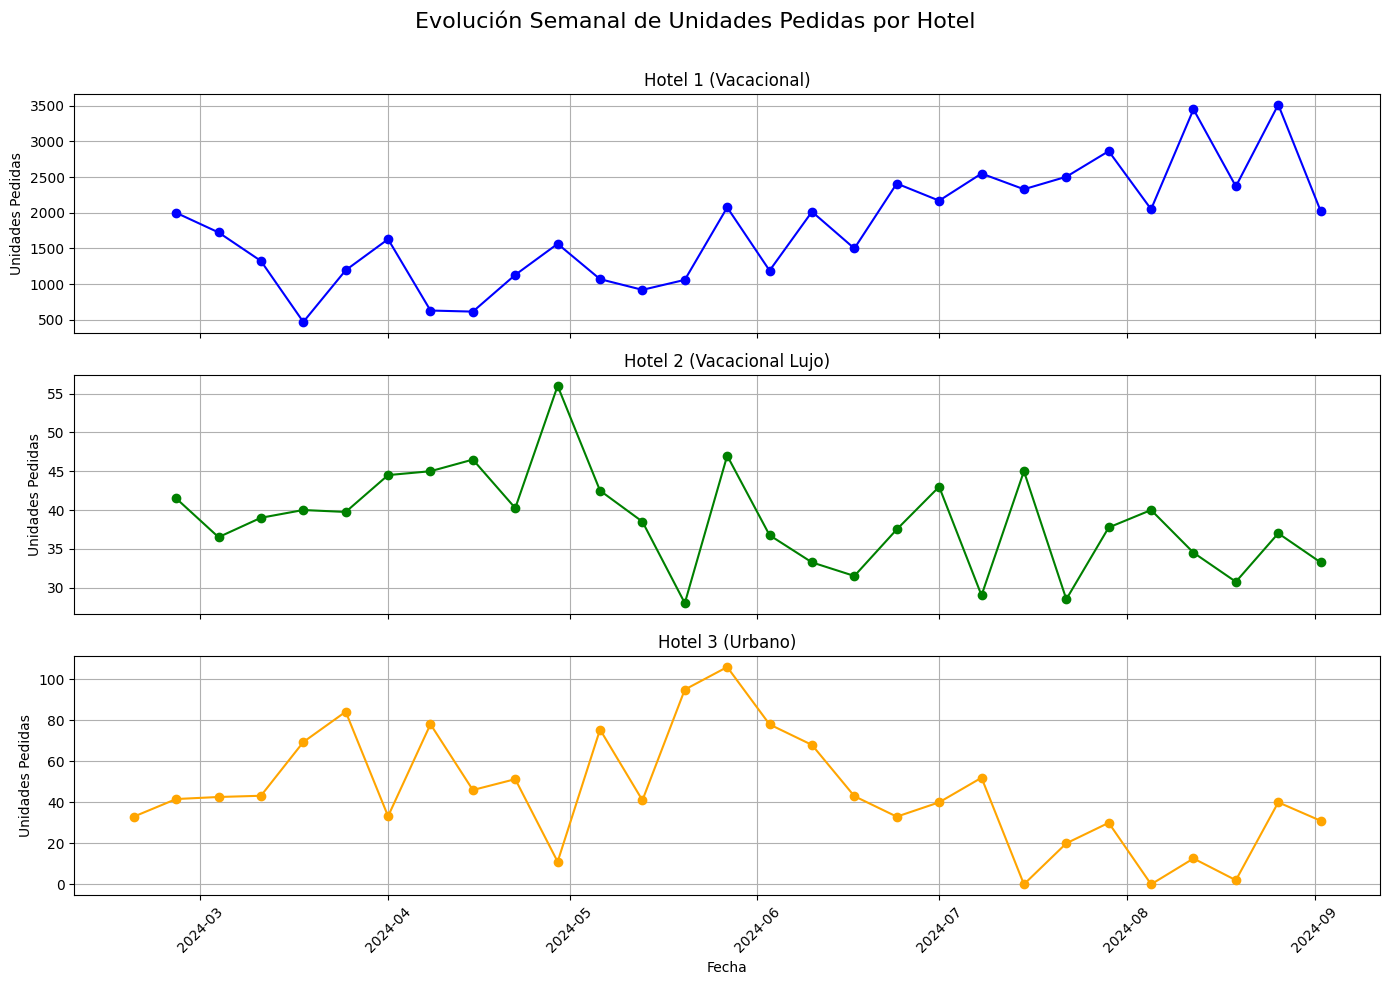

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los archivos (ajusta las rutas si los subes tú)
df1 = pd.read_excel("Copia de Predicciones_Hotel1.xlsx")
df2 = pd.read_excel("Copia de Predicciones_Hotel2.xlsx")
df3 = pd.read_excel("Copia de Predicciones_Hotel3.xlsx")

# Asegurar que la columna 'Fecha' esté en formato datetime
df1['Fecha'] = pd.to_datetime(df1['Fecha'])
df2['Fecha'] = pd.to_datetime(df2['Fecha'])
df3['Fecha'] = pd.to_datetime(df3['Fecha'])

# Eliminar la fila del forecast (última fila sin unidades reales)
df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()

# Crear figura con 3 subplots verticales
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Hotel 1
axes[0].plot(df1['Fecha'], df1['Unidades_Reales'], color='blue', marker='o')
axes[0].set_title('Hotel 1 (Vacacional)')
axes[0].set_ylabel('Unidades Pedidas')
axes[0].grid(True)

# Hotel 2
axes[1].plot(df2['Fecha'], df2['Unidades_Reales'], color='green', marker='o')
axes[1].set_title('Hotel 2 (Vacacional Lujo)')
axes[1].set_ylabel('Unidades Pedidas')
axes[1].grid(True)

# Hotel 3
axes[2].plot(df3['Fecha'], df3['Unidades_Reales'], color='orange', marker='o')
axes[2].set_title('Hotel 3 (Urbano)')
axes[2].set_ylabel('Unidades Pedidas')
axes[2].set_xlabel('Fecha')
axes[2].grid(True)

# Ajustes finales
plt.suptitle('Evolución Semanal de Unidades Pedidas por Hotel', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
